# Political stance classification using MLP with FastText


This notebook is a code for training a neural network which classify political orientation of the given text.

It requires 1.8.0 version of torch and nltk package as below. In the future we want to migrate it into 1.9.0

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet
!pip install nltk --quiet
!pip install fasttext --quiet

Before executing this notebook, please modify below paths for your own setup.

In [2]:
path_for_saving_model = '/content/drive/MyDrive/Data_NMA_Polaris/'
path_for_opening_data = './'

In [3]:
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt

# To make gpu availability and setting seed
import random
import torch

# To make Multi-layer percepton.
import torch.nn as nn
from torch.nn import functional as F

# To use pre-defined tokenization methods.
#from torchtext.legacy import data
from torchtext.legacy import data
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


# TO import Fast Text
import fasttext
from torchtext.vocab import FastText

embedding_fasttext = FastText('simple')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here, we use set_device() method to determine whether GPU (cuda) is available or not. Also, by setting the seed of random function, we ensure the reproducibility. This setting of the seed will be done by set_seed() method. These methods are provided by [Neuromath Academy] (https://academy.neuromatch.io)

In [4]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

Then, we define our neural network model as follow. It consists of 6 layers. First layer uses vector generated by embedding texts to FastText modele. Then, we have 5 linear layers with the same size, with dropout layers. After that, we determine the final classification using softmax.

In [5]:
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, dropout, output_size, hidden_size, vocab_size,
               embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.
    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      vocab_size: Integer
        Specifies the size of the vocabulary
        i.e. the number of tokens in the vocabulary
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.
    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.dropout = dropout
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=True)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc5 = nn.Linear(hidden_size, output_size)
    
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)
    self.dropout4 = nn.Dropout(dropout)
    self.dropout5 = nn.Dropout(dropout)
    self.dropout6 = nn.Dropout(dropout)

  def forward(self, inputs):
    """
    Compute the final labels by taking tokens as input.
    Args:
      inputs: Tensor
        Tensor of tokens in the text
    Returns:
      out: Tensor
        Final prediction Tensor
    """
    input = self.word_embeddings(inputs)  # convert text to embeddings
    # Average the word embedddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)
    # Pass the embeddings through the neural net
    # Use ReLU as the non-linearity
    x = self.fc1(self.dropout1(pooled))
    x = F.relu(x)
    x = self.fc2(self.dropout2(x))
    
    x = F.relu(self.dropout3(x))
    x = self.fc3(x)
    x = F.relu(self.dropout4(x))
    x = self.fc4(x)
    x = F.relu(self.dropout5(x))
    x = self.fc5(x)
    
    output = F.log_softmax(self.dropout6(x), dim=1)
    return output

This is a method for training. Here we use Cross Entropy loss function.

In [6]:
# Training
def train(model, device, train_iter, valid_iter, epochs, learning_rate, 
          reg=None):
  criterion = nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  if reg is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
    
  # early stopping
  best_acc = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 10

  # Keeps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      target = batch.relative_stance
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.relative_stance
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}% \n')

    # track best accuracy
    if ((correct/total) > best_acc):
      best_acc = (correct/total)
      best_epoch = epoch
      best_model = copy.deepcopy(output)
      wait = 0
    else:
      wait += 1

    if (wait > patience):
      print(f'Early stopped on epoch: {epoch + 1}')
      break
    
  return train_loss, train_acc, validation_loss, validation_acc

This the method for calculating test accuracy.

In [7]:
# Testing
def test(model, device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.relative_stance
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

We use dataset construction of Pytorch 1.8.0.

In [8]:
# Dataset
def tokenize(sentences):
  # Tokenize the sentence
  # from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)
  return token


def load_dataset(emb_vectors, seed, sentence_length=50, batch_size=32):
    print("Dataset loading...")
    
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True,
                        include_lengths=True, batch_first=True,
                        fix_length=sentence_length)


    LABEL = data.LabelField(dtype=torch.float)

    fields = {
     'text': ('text', TEXT),
     'relative_stance': ('relative_stance', LABEL),
    }

    train_data, test_data, valid_data = data.TabularDataset.splits(
       path = path_for_opening_data,
       train = "BIGNEWS_cleaned_train_204000.csv",
       test = "BIGNEWS_cleaned_test_25500.csv",
       validation = "BIGNEWS_cleaned_val_25500.csv",
       format = 'csv',
       fields = fields,
       skip_header = False
    )

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    datasets_ = (train_data, valid_data, test_data)
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(datasets_,
                                                                 batch_size=batch_size,
                                                                 sort_key=lambda x: len(x.text),
                                                                 repeat=False,
                                                                 shuffle=True)
    vocab_size = len(TEXT.vocab)
    print("Done!")
    return TEXT, vocab_size, train_iter, valid_iter, test_iter

Set up the function for ploting train-validation accuracies.

In [9]:
# Plotting
def plot_train_val(x, train, val, train_label, val_label, title, ylabel):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

These blocks are for set up hyperparameters.

In [10]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)


learning_rate = 0.0001
reg = 0.000005
dropout=0.60
output_size = 3
hidden_size = 12500
embedding_length = 300
epochs = 300


GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Random seed 2021 has been set.


Now we load data actually and tokenize them into test, train and validation sets. It takes 1 minutes for [dummy data](https://github.com/PolarisNMA2022/PoliticalStanceClassification/tree/main/dummy_data).

In [12]:
embedding_fasttext = FastText('simple')
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, seed=SEED)
word_embeddings = TEXT.vocab.vectors

Dataset loading...
Done!


Stat training! For [dummy data](https://github.com/PolarisNMA2022/PoliticalStanceClassification/tree/main/dummy_data), this take 40 minutes.

In [13]:

nn_model = NeuralNet(dropout, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate, reg)
print()
print(f"--- Time taken to train = {time.time() - nn_start_time} seconds ---")
test_accuracy = test(nn_model, DEVICE, test_iter)
print()
print(f'Test Accuracy: {test_accuracy}%')



Epoch: 1,  Training Loss: 1.1105, Training Accuracy:  34.49%
Validation Loss: 1.0925, Validation Accuracy:  37.72% 

Epoch: 2,  Training Loss: 1.0942, Training Accuracy:  36.49%
Validation Loss: 1.0714, Validation Accuracy:  45.30% 

Epoch: 3,  Training Loss: 1.0750, Training Accuracy:  39.81%
Validation Loss: 1.0525, Validation Accuracy:  46.84% 

Epoch: 4,  Training Loss: 1.0564, Training Accuracy:  42.44%
Validation Loss: 1.0345, Validation Accuracy:  50.54% 

Epoch: 5,  Training Loss: 1.0466, Training Accuracy:  43.35%
Validation Loss: 1.0101, Validation Accuracy:  52.08% 

Epoch: 6,  Training Loss: 1.0288, Training Accuracy:  44.87%
Validation Loss: 0.9941, Validation Accuracy:  53.85% 

Epoch: 7,  Training Loss: 1.0260, Training Accuracy:  45.43%
Validation Loss: 0.9773, Validation Accuracy:  55.50% 

Epoch: 8,  Training Loss: 1.0136, Training Accuracy:  46.62%
Validation Loss: 0.9693, Validation Accuracy:  56.18% 

Epoch: 9,  Training Loss: 1.0059, Training Accuracy:  47.14%
Val

Now you can draw a graph for accuracy changes per each epoch.

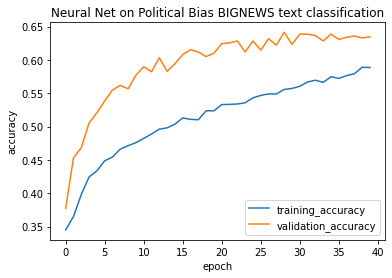

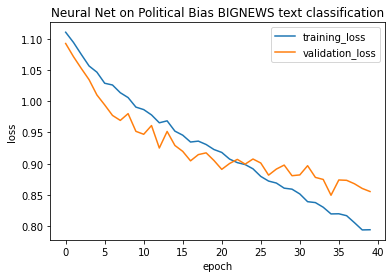

In [15]:
L = len(nn_train_acc)

plot_train_val(np.arange(0, L), nn_train_acc, nn_validation_acc,
               'training_accuracy', 'validation_accuracy',
               'Neural Net on Political Bias BIGNEWS text classification', 'accuracy')
plot_train_val(np.arange(0, L), nn_train_loss, nn_validation_loss,
               'training_loss', 'validation_loss',
               'Neural Net on Political Bias BIGNEWS text classification', 'loss')